In [157]:
import pandas as pd
import glob
import os

In [159]:
file_paths = glob.glob("data-*")  

print(f"Total files found: {len(file_paths)}")
file_paths[:5]  

Total files found: 70


['data-31', 'data-36', 'data-09', 'data-07', 'data-38']

In [161]:
all_records = []

for file in sorted(file_paths):  
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 4:
                all_records.append(parts)

df = pd.DataFrame(all_records, columns=["Date", "Time", "Code", "Value"])

In [163]:
df["Code"] = pd.to_numeric(df["Code"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors='coerce')
df = df[["DateTime", "Date", "Time", "Code", "Value"]]

In [165]:
code_map = {
    33: "Regular insulin dose", 34: "NPH insulin dose", 35: "UltraLente insulin dose",
    48: "Unspecified blood glucose", 57: "Unspecified blood glucose",
    58: "Pre-breakfast blood glucose", 59: "Post-breakfast blood glucose",
    60: "Pre-lunch blood glucose", 61: "Post-lunch blood glucose",
    62: "Pre-supper blood glucose", 63: "Post-supper blood glucose",
    64: "Pre-snack blood glucose", 65: "Hypoglycemic symptoms",
    66: "Typical meal ingestion", 67: "More-than-usual meal ingestion",
    68: "Less-than-usual meal ingestion", 69: "Typical exercise activity",
    70: "More-than-usual exercise activity", 71: "Less-than-usual exercise activity",
    72: "Special event"
}
df["Event"] = df["Code"].map(code_map)

In [167]:
df.sort_values("DateTime", inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv("diabetes_dataset_cleaned.csv", index=False)

In [169]:
df.head(10)  


,DateTime,Date,Time,Code,Value,Event
0,1988-03-27 08:00:00,03-27-1988,08:00,58,134.0,Pre-breakfast blood glucose
1,1988-03-27 08:00:00,03-27-1988,08:00,34,20.0,NPH insulin dose
2,1988-03-27 12:00:00,03-27-1988,12:00,60,158.0,Pre-lunch blood glucose
3,1988-03-27 18:00:00,03-27-1988,18:00,62,258.0,Pre-supper blood glucose
4,1988-03-28 08:00:00,03-28-1988,08:00,34,20.0,NPH insulin dose
5,1988-03-28 08:00:00,03-28-1988,08:00,58,115.0,Pre-breakfast blood glucose
6,1988-03-28 12:00:00,03-28-1988,12:00,60,162.0,Pre-lunch blood glucose
7,1988-03-28 18:00:00,03-28-1988,18:00,62,135.0,Pre-supper blood glucose
8,1988-03-31 08:00:00,03-31-1988,08:00,58,100.0,Pre-breakfast blood glucose
9,1988-03-31 08:00:00,03-31-1988,08:00,34,20.0,NPH insulin dose


In [171]:
from IPython.display import FileLink
FileLink('diabetes_dataset_cleaned.csv')


/Users/eswarkamisetti/diabetes_dataset_cleaned.csv

In [173]:
df = pd.read_csv("diabetes_dataset_cleaned.csv")

glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
glucose_df = df[df["Code"].isin(glucose_codes)].copy()


In [175]:
glucose_df["DateTime"] = pd.to_datetime(glucose_df["Date"] + " " + glucose_df["Time"])
glucose_df.set_index("DateTime", inplace=True)
glucose_df.sort_index(inplace=True)


ValueError: day is out of range for month, at position 13526. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [177]:
glucose_df["datetime_str"] = glucose_df["Date"] + " " + glucose_df["Time"]

glucose_df["DateTime"] = pd.to_datetime(glucose_df["datetime_str"], errors='coerce')

invalid_dates_df = glucose_df[glucose_df["DateTime"].isna()]

print("Number of invalid datetime rows:", len(invalid_dates_df))
invalid_dates_df[["Date", "Time", "Code", "Value", "Event"]]

Number of invalid datetime rows: 5


,Date,Time,Code,Value,Event
29252,06-31-1991,07:50,58,149.0,Pre-breakfast blood glucose
29255,06-31-1991,13:30,60,162.0,Pre-lunch blood glucose
29257,06-31-1991,19:45,62,213.0,Pre-supper blood glucose
29259,04-09-1991,56:35,58,237.0,Pre-breakfast blood glucose
29262,04-21-1991,188:00,62,128.0,Pre-supper blood glucose


In [179]:

glucose_df = glucose_df[glucose_df["DateTime"].notna()]


In [181]:
glucose_df.set_index("DateTime", inplace=True)



In [183]:
glucose_df.index 

DatetimeIndex(['1988-03-27 08:00:00', '1988-03-27 12:00:00',
               '1988-03-27 18:00:00', '1988-03-28 08:00:00',
               '1988-03-28 12:00:00', '1988-03-28 18:00:00',
               '1988-03-31 08:00:00', '1988-03-31 12:00:00',
               '1988-03-31 18:00:00', '1988-04-02 08:00:00',
               ...
               '1991-09-21 14:30:00', '1991-09-21 19:50:00',
               '1991-09-22 08:35:00', '1991-09-22 11:30:00',
               '1991-09-22 17:45:00', '1991-09-22 22:15:00',
               '1991-09-23 07:45:00', '1991-09-23 12:15:00',
               '1991-09-23 17:15:00', '1991-09-23 21:10:00'],
              dtype='datetime64[ns]', name='DateTime', length=13526, freq=None)

In [185]:
glucose_series = glucose_df["Value"].resample("1h").mean().interpolate()


In [187]:
import numpy as np

def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)


In [189]:
window_size = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(glucose_series.values, window_size)

X = X.reshape((X.shape[0], X.shape[1], 1))


In [191]:
print("X shape:", X.shape)  # (samples, 24, 1)
print("y shape:", y.shape)  # (samples,)


X shape: (30590, 24, 1)
y shape: (30590,)


In [193]:
!pip install tensorflow


In [194]:
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(glucose_series.values, window_size)

X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM


In [197]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential([
    Input(shape=(24, 1)),
    LSTM(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,           # You can increase to 20+ once verified
    batch_size=32,
    verbose=1
)


Epoch 1/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10660.0469 - val_loss: 4941.8174
Epoch 2/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2291.5205 - val_loss: 4360.1660
Epoch 3/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2149.9824 - val_loss: 3152.1899
Epoch 4/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1009.1520 - val_loss: 3486.9153
Epoch 5/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 897.2171 - val_loss: 2743.6274
Epoch 6/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 813.7974 - val_loss: 2630.3684
Epoch 7/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 785.5463 - val_loss: 2697.3401
Epoch 8/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 782.5585 - val_loss: 2648.7805
Epoch 9/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 782.7053 - val_loss: 2718.3386
Epoch 10/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 748.0816 - val_loss: 2622.8564


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


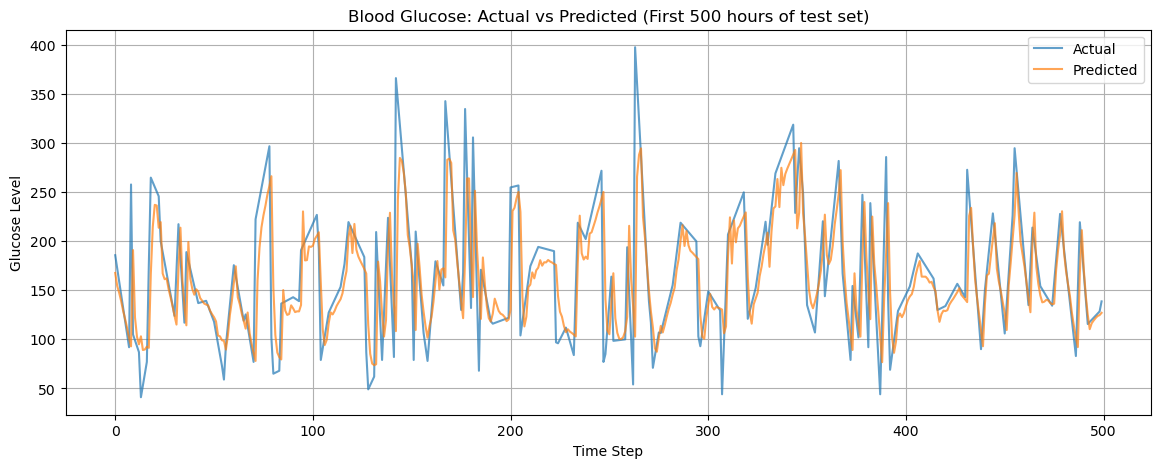

In [203]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_test[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title("Blood Glucose: Actual vs Predicted (First 500 hours of test set)")
plt.xlabel("Time Step")
plt.ylabel("Glucose Level")
plt.legend()
plt.grid(True)
plt.show()


In [205]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

glucose_values = glucose_series.values.reshape(-1, 1)

scaler = MinMaxScaler()
glucose_scaled = scaler.fit_transform(glucose_values).flatten()


In [207]:
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(glucose_scaled, window_size=window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [213]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0072 - val_loss: 0.0119
Epoch 2/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - val_loss: 0.0124
Epoch 3/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 4/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0032 - val_loss: 0.0120


In [215]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


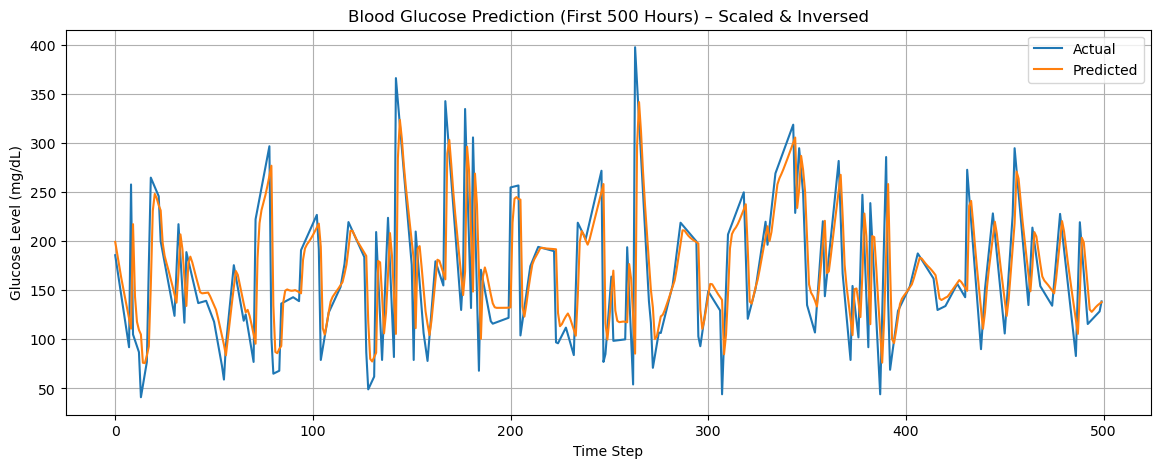

In [217]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_true[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.title("Blood Glucose Prediction (First 500 Hours) – Scaled & Inversed")
plt.xlabel("Time Step")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.grid(True)
plt.show()


In [219]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")


Test MSE: 2776.58
Test MAE: 34.73


In [221]:
model.save("univariate_lstm_model.h5")

import joblib
joblib.dump(scaler, "univariate_scaler.pkl")


['univariate_scaler.pkl']

In [223]:

df_hourly = pd.DataFrame(index=glucose_series.index)
df_hourly["glucose"] = glucose_series


In [225]:

insulin_df["DateTime"] = pd.to_datetime(insulin_df["Date"] + " " + insulin_df["Time"], errors='coerce')
meal_df["DateTime"] = pd.to_datetime(meal_df["Date"] + " " + meal_df["Time"], errors='coerce')

insulin_df.dropna(subset=["DateTime"], inplace=True)
meal_df.dropna(subset=["DateTime"], inplace=True)


/var/folders/sh/nvkvr0rn4752gjdwsn5pv4h40000gn/T/ipykernel_44482/1995580521.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insulin_df["DateTime"] = pd.to_datetime(insulin_df["Date"] + " " + insulin_df["Time"], errors='coerce')
/var/folders/sh/nvkvr0rn4752gjdwsn5pv4h40000gn/T/ipykernel_44482/1995580521.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  meal_df["DateTime"] = pd.to_datetime(meal_df["Date"] + " " + meal_df["Time"], errors='coerce')


In [227]:

insulin_df["DateTime"] = insulin_df["DateTime"].dt.round("h")
meal_df["DateTime"] = meal_df["DateTime"].dt.round("h")

insulin_hourly = insulin_df.groupby("DateTime")["Value"].sum()
meal_hourly = meal_df.groupby("DateTime")["Value"].sum()


In [229]:

df_hourly["hour"] = df_hourly.index.hour

df_hourly["hour_sin"] = np.sin(2 * np.pi * df_hourly["hour"] / 24)
df_hourly["hour_cos"] = np.cos(2 * np.pi * df_hourly["hour"] / 24)

df_hourly.drop(columns="hour", inplace=True)


In [231]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_hourly)

df_scaled = pd.DataFrame(scaled_array, index=df_hourly.index, columns=df_hourly.columns)


In [233]:
def create_multivariate_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])  # predict glucose only
    return np.array(X), np.array(y)

window_size = 24
X_mv, y_mv = create_multivariate_sequences(df_scaled.values, window_size=window_size)


In [235]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_mv, y_mv, test_size=0.2, shuffle=False
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential([
    Input(shape=(window_size, X_mv.shape[2])),
    LSTM(64, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0136 - val_loss: 0.0118
Epoch 2/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0036 - val_loss: 0.0124
Epoch 3/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0033 - val_loss: 0.0118
Epoch 4/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0032 - val_loss: 0.0119
Epoch 5/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034 - val_loss: 0.0122
Epoch 6/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034 - val_loss: 0.0120
Epoch 7/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034 - val_loss: 0.0119
Epoch 8/30
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034 - val_loss: 0.0118
Epoch 9/30
316/765 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035

In [ ]:
y_pred_scaled = model.predict(X_test)

y_true = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_pred = scaler.inverse_transform(
    np.concatenate([y_pred_scaled, X_test[:, -1, 1:]], axis=1)
)[:, 0]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_true[:500], label="Actual")
plt.plot(y_pred[:500], label="Predicted")
plt.title("Multivariate LSTM: Glucose Prediction (First 500 hours)")
plt.xlabel("Time Step")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.grid(True)
plt.show()


In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Multivariate Test MSE: {mse:.2f}")
print(f"Multivariate Test MAE: {mae:.2f} mg/dL")


Multivariate Test MSE: 2728.61
Multivariate Test MAE: 32.48 mg/dL


In [142]:

model.save("multivariate_lstm_model.h5")

joblib.dump(scaler, "multivariate_scaler.pkl")


['multivariate_scaler.pkl']

In [152]:
import pandas as pd
import numpy as np

uni_dates = pd.date_range(end=pd.Timestamp.now(), periods=24, freq="H")
uni_glucose = np.random.randint(100, 180, size=24)

df_univariate = pd.DataFrame({
    "DateTime": uni_dates,
    "glucose": uni_glucose
})
df_univariate.set_index("DateTime", inplace=True)
df_univariate.to_csv("univariate_input.csv")


/var/folders/sh/nvkvr0rn4752gjdwsn5pv4h40000gn/T/ipykernel_44482/3799074948.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  uni_dates = pd.date_range(end=pd.Timestamp.now(), periods=24, freq="H")


In [154]:
multi_dates = pd.date_range(end=pd.Timestamp.now(), periods=24, freq="H")
multi_glucose = np.random.randint(100, 180, size=24)
insulin = np.random.randint(0, 30, size=24)
meal = np.random.randint(0, 3, size=24)

df_multivariate = pd.DataFrame({
    "DateTime": multi_dates,
    "glucose": multi_glucose,
    "insulin": insulin,
    "meal": meal
})
df_multivariate["hour"] = df_multivariate["DateTime"].dt.hour
df_multivariate["hour_sin"] = np.sin(2 * np.pi * df_multivariate["hour"] / 24)
df_multivariate["hour_cos"] = np.cos(2 * np.pi * df_multivariate["hour"] / 24)
df_multivariate.drop(columns="hour", inplace=True)
df_multivariate.set_index("DateTime", inplace=True)
df_multivariate.to_csv("multivariate_input.csv")



/var/folders/sh/nvkvr0rn4752gjdwsn5pv4h40000gn/T/ipykernel_44482/2120542272.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  multi_dates = pd.date_range(end=pd.Timestamp.now(), periods=24, freq="H")
